In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

sns.set_theme(style='whitegrid')
np.random.seed(42)

In [3]:
# loading a numpy-array containing the topological data
z = np.load('topographical_data.npy')[4650:4900, 800:1050]

# --- Generating dataset
n = 250 # the square root of the number of datapoints
x, y = np.linspace(0,n,n), np.linspace(0, n, n)
x, y = np.meshgrid(x, y)
x = x.ravel()
y = y.ravel()

z = z.ravel()

X = np.column_stack((x,y))
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)

k_folds = KFold(n_splits=10)

### OLS

In [35]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('linearregressor', LinearRegression())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4, 5],
}

grid_search = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=k_folds,
                  n_jobs=-1)
gs = grid_search.fit(X_train, z_train)
print(-gs.best_score_)
print(gs.best_params_)

1878.868761526055
{'poly__degree': 5}


### Ridge

In [36]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4, 5],
    'ridge__alpha': np.logspace(-4, 1, 6)
}

grid_search = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=k_folds,
                  n_jobs=-1)
gs = grid_search.fit(X_train, z_train)
print(-gs.best_score_)
print(gs.best_params_)

1878.8693377381337
{'poly__degree': 5, 'ridge__alpha': 0.0001}


### Lasso

In [37]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4, 5],
    'lasso__alpha': np.logspace(-4, 1, 6)
}

grid_search = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=k_folds,
                  n_jobs=-1)
gs = grid_search.fit(X_train, z_train)
print(-gs.best_score_)
print(gs.best_params_)

3690.8914016227304
{'lasso__alpha': 0.0001, 'poly__degree': 5}


c:\Users\maria\anaconda3\envs\fysstk3155\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.214e+07, tolerance: 6.344e+04
  model = cd_fast.enet_coordinate_descent(


### Validation curve

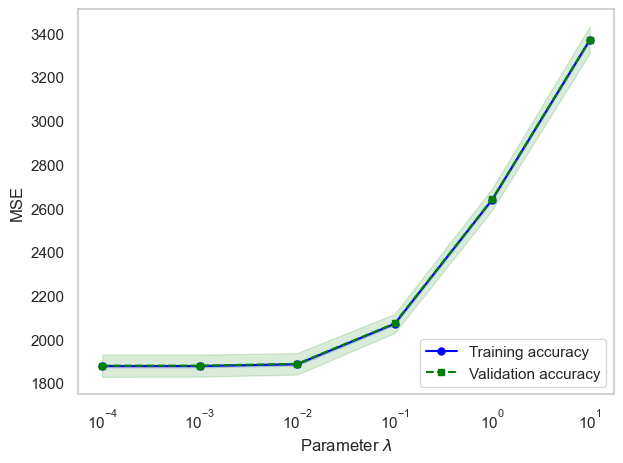

In [33]:
pipeline = make_pipeline(
                    PolynomialFeatures(degree=5),
                    StandardScaler(),
                    Ridge())

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
train_scores, test_scores = validation_curve(
                estimator=pipeline, 
                X=X_train, 
                y=z_train, 
                param_name='ridge__alpha', 
                param_range=param_range,
                cv=k_folds,
                scoring='neg_mean_squared_error')

train_mean = np.mean(np.abs(train_scores), axis=1)
train_std = np.std(np.abs(train_scores), axis=1)
test_mean = np.mean(np.abs(test_scores), axis=1)
test_std = np.std(np.abs(test_scores), axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel(r'Parameter $\lambda$')
plt.ylabel('MSE')
#plt.ylim([-0.1, 0.1])
plt.tight_layout()
# plt.savefig('figures/06_06.png', dpi=300)
plt.show()

## Higher Degree Fit

### OLS

In [10]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

param_grid = [
    {
        'model': [LinearRegression()],
        'poly__degree': list(range(1, 11)),
    },
    {
        'model': [Ridge()],
        'poly__degree': list(range(1, 11)),
        'model__alpha': np.logspace(-4, 1, 6),
    }
#     {
#         'model': [Lasso()],
#         'poly__degree': list(range(1, 11)),
#         'model__alpha': np.logspace(-4, 1, 6),
#     }
]

grid_search = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=k_folds,
                  n_jobs=1,
                  verbose=5)
gs = grid_search.fit(X_train, z_train)
print(-gs.best_score_)
print(gs.best_params_)

Fitting 10 folds for each of 70 candidates, totalling 700 fits
[CV 1/10] END model=LinearRegression(), poly__degree=1;, score=-12030.571 total time=   0.0s
[CV 2/10] END model=LinearRegression(), poly__degree=1;, score=-12794.099 total time=   0.0s
[CV 3/10] END model=LinearRegression(), poly__degree=1;, score=-12317.277 total time=   0.0s
[CV 4/10] END model=LinearRegression(), poly__degree=1;, score=-12008.520 total time=   0.0s
[CV 5/10] END model=LinearRegression(), poly__degree=1;, score=-12483.236 total time=   0.0s
[CV 6/10] END model=LinearRegression(), poly__degree=1;, score=-11823.709 total time=   0.0s
[CV 7/10] END model=LinearRegression(), poly__degree=1;, score=-12267.726 total time=   0.0s
[CV 8/10] END model=LinearRegression(), poly__degree=1;, score=-12305.680 total time=   0.0s
[CV 9/10] END model=LinearRegression(), poly__degree=1;, score=-12098.822 total time=   0.0s
[CV 10/10] END model=LinearRegression(), poly__degree=1;, score=-12437.259 total time=   0.0s
[CV 1/

### Ridge

In [4]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

param_grid = {
    'poly__degree': list(range(1, 11)),
    'ridge__alpha': np.logspace(-4, 1, 6)
}

grid_search = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=k_folds,
                  n_jobs=-1)
gs = grid_search.fit(X_train, z_train)
print(-gs.best_score_)
print(gs.best_params_)

894.6938095540203
{'poly__degree': 10, 'ridge__alpha': 0.0001}


### Lasso

In [6]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

param_grid = {
    'poly__degree': list(range(1, 11)),
    'lasso__alpha': np.logspace(-4, 1, 6)
}

grid_search = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=k_folds,
                  n_jobs=-1)
gs = grid_search.fit(X_train, z_train)
print(-gs.best_score_)
print(gs.best_params_)

2447.221340776895
{'lasso__alpha': 0.01, 'poly__degree': 10}


c:\Users\maria\anaconda3\envs\fysstk3155\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.270e+07, tolerance: 6.344e+04
  model = cd_fast.enet_coordinate_descent(
